In [44]:
import sys  
sys.path.insert(0, './machine_learning_models')

import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from helpers.file import save_file
from joblib import dump
pd.set_option('mode.chained_assignment', None)

In [45]:
first_season = 2012
last_season = 2023

save_models = False

season_file = f'{first_season}-{last_season}'

min_odds = 1.8

first_attr_index = 6
target_index = -3

In [46]:
print('\nGetting data for the model...')

dataset = pd.read_csv('../data/{}.csv'.format(season_file), index_col = 0)
dataset = dataset.loc[(dataset['ODDS_A'].notna()) & (dataset['ODDS_B'].notna())]
dataset['GAME_DATE'] = pd.to_datetime(dataset['GAME_DATE']).dt.date

display(dataset.tail(2))


Getting data for the model...


,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,WINNER,GAME_PTS_A,GAME_PTS_B
11966,2023,2024-01-22,ORL,CLE,2.12,1.75,107.8,110.3,0.4531,0.3583,...,0.7,0.588235,7,0.8,0.6,117.749453,103.199365,A,99,126
11967,2023,2024-01-22,PHI,SAS,1.76,2.11,111.8,111.6,0.4513,0.3465,...,0.2,0.217391,1,0.3,0.4,113.138427,112.446555,H,133,123


In [47]:
# dependent_variables = dataset.iloc[:,first_attr_index:]
# dependent_variables.corr()

In [48]:
def train_predict_model(x_train, y_train, x_test, y_test, season, model):
    model_abbv = model['abbreviation']
    classifier = model['classifier']
    
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)
    predictions_probabilities = classifier.predict_proba(x_test)
    
    if save_models and season == last_season:
        save_file('../models', classifier, model_abbv)
    
    results_df = pd.DataFrame({
        f"{model_abbv}_PRED": predictions,
        f"{model_abbv}_PROBS_A": predictions_probabilities[:, 1],
        f"{model_abbv}_PROBS_B": predictions_probabilities[:, 0],
    })
    
    return results_df

In [49]:
main_df = pd.DataFrame()

for season in range(first_season + 1, last_season+1):
    rf_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
    gb_classifier = GradientBoostingClassifier(random_state=0)
    lr_classifier = LogisticRegression()
    svm_classifier = SVC(kernel='rbf', random_state=0, probability=True)

    # Create a voting classifier
    voting_classifier = VotingClassifier(
        estimators=[
            ('RF', rf_classifier),
            ('GB', gb_classifier),
        ],
        voting='soft'  # Use 'soft' for probability voting
    )
    
    models = [
        {'classifier': rf_classifier, 'abbreviation': 'RF'},
        {'classifier': gb_classifier, 'abbreviation': 'GB'},
        {'classifier': svm_classifier, 'abbreviation': 'SVM'},
        {'classifier': lr_classifier, 'abbreviation': 'LR'},
        {'classifier': voting_classifier, 'abbreviation': 'VC'},
        {'classifier': GaussianNB(), 'abbreviation': 'NB'},
        {'classifier': KNeighborsClassifier(n_neighbors=500), 'abbreviation': 'KNN'},
        {'classifier': SGDClassifier(loss="log", random_state = 0), 'abbreviation': 'SGD'}, 
    ]
    
    columns = dataset.columns[first_attr_index:target_index-1]
    target_col = dataset.columns[target_index]

    train_dataset = dataset[dataset['SEASON_ID'] < season]
    x_train = train_dataset[columns]
    y_train = train_dataset[target_col]

    test_dataset = dataset[dataset['SEASON_ID'] == season]
    x_test = test_dataset[columns]
    y_test = test_dataset[target_col]

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if save_models and season == last_season:
        save_file('../scalers', scaler, 'scaler')
    
    for model in models:
        clear_output(wait=True)
        
        model_abbv = model["abbreviation"]
        print(f"{season}/{last_season} - {model_abbv}")
        
        results_df = train_predict_model(x_train_scaled, y_train, x_test_scaled, y_test, season, model)
        results_df.set_index(test_dataset.index, inplace=True)
        
        test_dataset = pd.merge(test_dataset, results_df, left_index=True, right_index=True)

    if main_df.empty:
        main_df = test_dataset
    else:
        main_df = pd.concat([main_df, test_dataset], ignore_index=True)

2023/2023 - SGD


In [50]:
def create_game_profit_col(row, model_abbv):
    odds = row["ODDS_A" if row[f"{model_abbv}_PRED"] == "H" else "ODDS_B"]
    pred_odds = 1 / (
        row[
            f"{model_abbv}_PROBS_A"
            if row[f"{model_abbv}_PRED"] == "H"
            else f"{model_abbv}_PROBS_B"
        ]
    )

    bet_valid = odds > min_odds and pred_odds < odds

    if bet_valid and row["WINNER"] == row[f"{model_abbv}_PRED"]:
        return odds - 1
    elif bet_valid:
        return -1
    else:
        return 0


display(main_df.head(2))

in_depth_models_for_analysis = ["RF", "GB", "SVM", "LR", "VC"]

# Initialize an empty DataFrame to store season-wise statistics
season_stats = pd.DataFrame(columns=["Season"])

for model in models:
    model_abbv = model["abbreviation"]

    main_df[f"{model_abbv}_PROFIT"] = main_df.apply(
        lambda x: create_game_profit_col(x, model_abbv), axis=1
    )
    main_df[f"{model_abbv}_PROFIT_TRACKING"] = main_df[f"{model_abbv}_PROFIT"].cumsum()
    main_df[f"{model_abbv}_STRIKE"] = (
        main_df[f"{model_abbv}_PRED"] == main_df["WINNER"]
    ).astype(int)

    # Calculate Net Gains
    net_gains = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]

    # Calculate Yield
    total_profit = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]
    total_bets = len(main_df)
    yield_percentage = (total_profit / total_bets) * 100

    # Calculate Strike Rate
    correct_predictions = main_df[f"{model_abbv}_STRIKE"].sum()
    strike_rate_percentage = (correct_predictions / total_bets) * 100

    # Print the results
    print(f"\n{model_abbv} Net Gains: {net_gains}")
    print(f"{model_abbv} Yield: {yield_percentage:.2f}%")
    print(f"{model_abbv} Strike Rate: {strike_rate_percentage:.2f}%")

    if model_abbv not in in_depth_models_for_analysis:
        continue

    # Group by season and calculate overall stats
    model_season_stats = main_df.groupby("SEASON_ID").agg(
        {
            f"{model_abbv}_PROFIT_TRACKING": lambda x: x.iloc[-1] - x.iloc[0],
            f"{model_abbv}_PROFIT": lambda x: (
                x != 0
            ).sum(),  # Counting only non-zero profits as bets
        }
    )

    # Rename columns for clarity
    model_season_stats.columns = [f"{model_abbv}_Net_Gains", f"{model_abbv}_Total_Bets"]

    # Calculate additional statistics
    model_season_stats[f"{model_abbv}_Yield"] = (
        model_season_stats[f"{model_abbv}_Net_Gains"]
        / model_season_stats[f"{model_abbv}_Total_Bets"]
    ) * 100

    # Merge with the overall season_stats DataFrame
    season_stats = pd.merge(
        season_stats,
        model_season_stats,
        left_on="Season",
        right_index=True,
        how="outer",
    )

season_stats.drop("Season", axis=1, inplace=True)

,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,VC_PROBS_B,NB_PRED,NB_PROBS_A,NB_PROBS_B,KNN_PRED,KNN_PROBS_A,KNN_PROBS_B,SGD_PRED,SGD_PROBS_A,SGD_PROBS_B
0,2013,2013-11-16,MIN,BOS,1.18,5.03,108.7,101.4,0.4437,0.3571,...,0.219000,H,0.997468,0.002532,H,0.704,0.296,H,0.998035,0.001965
1,2013,2013-11-18,DAL,PHI,1.10,7.27,106.6,103.6,0.4708,0.3986,...,0.294817,H,0.999688,0.000312,H,0.728,0.272,H,0.999333,0.000667



RF Net Gains: 177.27999999999994
RF Yield: 1.63%
RF Strike Rate: 65.60%

GB Net Gains: 148.46999999999986
GB Yield: 1.36%
GB Strike Rate: 65.31%

SVM Net Gains: 102.37999999999988
SVM Yield: 0.94%
SVM Strike Rate: 65.37%

LR Net Gains: 112.2100000000001
LR Yield: 1.03%
LR Strike Rate: 66.05%

VC Net Gains: 238.24999999999991
VC Yield: 2.19%
VC Strike Rate: 66.22%

NB Net Gains: 76.57999999999998
NB Yield: 0.70%
NB Strike Rate: 64.61%

KNN Net Gains: 80.18000000000006
KNN Yield: 0.74%
KNN Strike Rate: 65.18%

SGD Net Gains: 117.40000000000009
SGD Yield: 1.08%
SGD Strike Rate: 64.01%


In [51]:
display(season_stats)

,RF_Net_Gains,RF_Total_Bets,RF_Yield,GB_Net_Gains,GB_Total_Bets,GB_Yield,SVM_Net_Gains,SVM_Total_Bets,SVM_Yield,LR_Net_Gains,LR_Total_Bets,LR_Yield,VC_Net_Gains,VC_Total_Bets,VC_Yield
SEASON_ID,,,,,,,,,,,,,,,
2013,-26.33,241,-10.925311,-6.57,268,-2.451493,-19.17,234,-8.192308,-22.76,237,-9.603376,-12.59,244,-5.159836
2014,33.39,211,15.824645,55.48,247,22.461538,18.43,212,8.693396,21.18,184,11.510870,60.29,221,27.280543
2015,40.78,220,18.536364,10.21,216,4.726852,24.19,213,11.356808,45.51,165,27.581818,28.68,202,14.198020
2016,41.39,202,20.490099,14.22,217,6.552995,37.58,244,15.401639,0.64,186,0.344086,38.34,201,19.074627
2017,15.98,234,6.829060,31.52,190,16.589474,0.42,227,0.185022,-1.52,192,-0.791667,25.36,205,12.370732
2018,13.61,218,6.243119,4.31,223,1.932735,12.69,233,5.446352,5.56,176,3.159091,15.53,216,7.189815
2019,44.33,205,21.624390,24.16,206,11.728155,23.15,204,11.348039,27.33,179,15.268156,40.37,197,20.492386
2020,-6.07,207,-2.932367,-0.44,215,-0.204651,31.17,211,14.772512,4.55,194,2.345361,-1.29,197,-0.654822
2021,4.70,196,2.397959,3.77,199,1.894472,-23.01,196,-11.739796,-6.58,179,-3.675978,19.47,185,10.524324


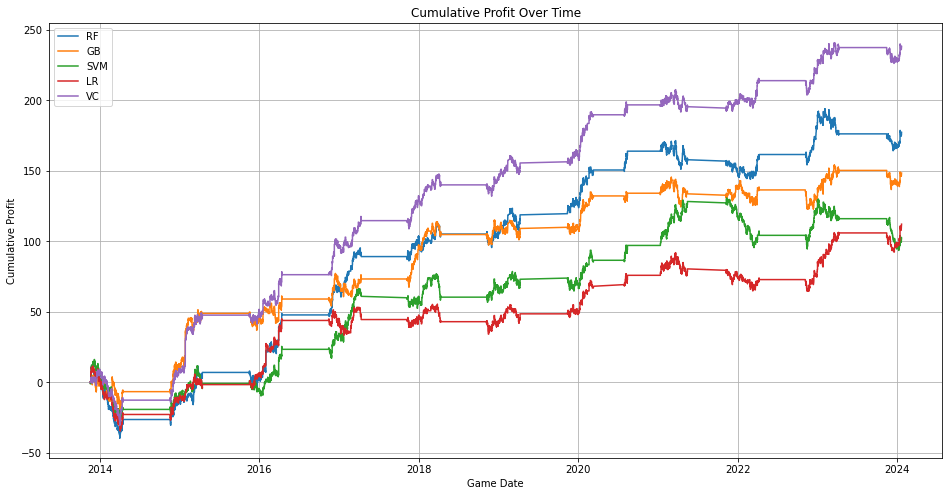

In [52]:
plt.figure(figsize=(16, 8))

for model in models:
    model_abbv = model["abbreviation"]
    if model_abbv in in_depth_models_for_analysis:
        plt.plot(main_df['GAME_DATE'], main_df[f"{model_abbv}_PROFIT_TRACKING"], label = model_abbv)
    
plt.title('Cumulative Profit Over Time')
plt.xlabel('Game Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.grid(True)
plt.show()

#### 